In [1]:
import os
import numpy as np
import numpy.random as rnd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline

In [8]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 2
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r'$\alpha = {}$'.format(alpha))
    
    plt.plot(X, y, 'b.', linewidth=3)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0, 3, 0, 4])

# リッジ回帰

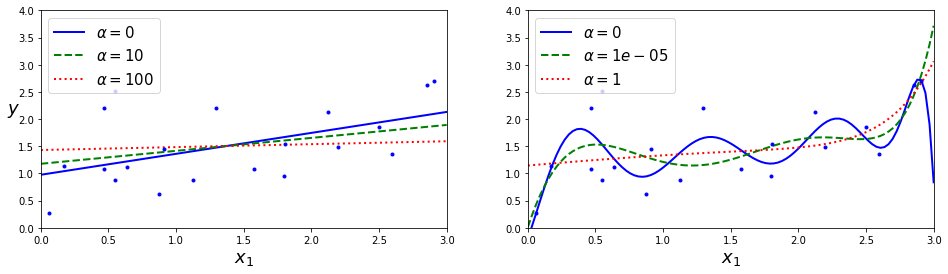

In [11]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

左は線形モデル，右は多項式モデル．αを大きくすると，平板化する（バイアスが大きくなる）．

線形回帰と同様リッジ回帰も閉形式によりパラメータを求めることができる（解析的に解くことができる）

コレスキーの行列分解テクニックを使う

In [12]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

L2正則化のSGDと比較

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.Infinity, penalty='l2', random_state=42)
sgd_reg.fit(X, y.ravel())
ridge_reg.predict([[1.5]])

array([[1.55071465]])

同じ！

ちなみに，solverを「sag」＝（Stocastic Average Gradient Descent）にしたRidgeクラスも使うことができる

In [15]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

少し異なる

# Lasso回帰

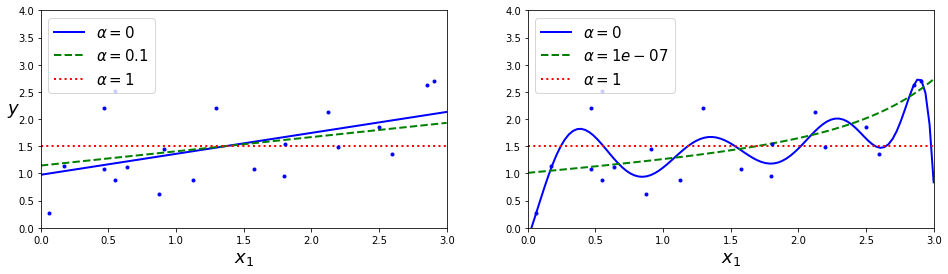

In [18]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(16,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

Lasso回帰は，L1ノルムを使う．これは，重要性の低い特徴量は全て取り除いてしまうという性質があり，右のグラフの緑線が顕著である（リッジと比べほぼ２次元）

In [19]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

# Elastic Net

リッジ回帰とLasso回帰の中間．それぞれを混ぜる割合rを指定する．

In [22]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# どう使い分けるか

ほとんど全ての場合，正則化すべき（そうしないとコスト関数を最小化する目的なのでどんどん過学習していく）なので，プレーンな線形回帰は避けるべき

リッジ回帰は良いデフォルトになるが，あまり意味のなさそうな特徴量の重みを０に引き下げてくれるLasso回帰やElasticNetも使いたい．

Lassoはサンプル数より特徴量の数の方が多いときや，複数の特徴量間に強い相関があるとき（要は個々の特徴量自体が強い意味を持つとき）は不規則な動きをしがちなので，ElasticNetの方が良い．

# 早期打ち切り

検証誤差が最小値に達したところでエポックを打ち切る

「ノーフリーランチ定理」：かつて酒場で「飲みに来た客には昼食を無料で振る舞う」という宣伝が行われたが、「無料の昼食」の代金は酒代に含まれていて実際には「無料の昼食」なんてものは有る訳がないだろう

つまり，あらゆる問題で性能の良い汎用最適化戦略は理論上不可能であり，ある問題で最適戦略でも（この世に存在する）別の問題では最適戦略とは言えない．

つまり，「解こうとしている問題に対し，必ず前提を設けないと何がいいとは言えない」

という考え方がある中で，「早期打ち切り」は単純な上に効率的な正則化テクニックであることからジェフェリーヒントンは「素晴らしいフリーランチ」と呼んでいる

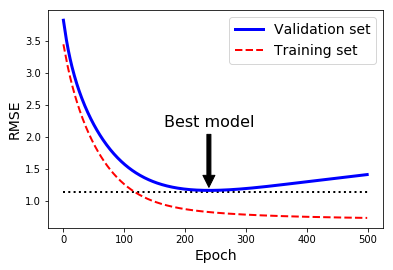

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(
    max_iter=1,
    tol=-np.infty,
    penalty=None,
    eta0=0.0005,
    warm_start=True, # fit()が訓練の時に前回の訓練後の状態から訓練を続ける（epochで訓練する時に指定すること）
    learning_rate='constant',
    random_state=42
)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate(
    'Best model',
    xy = (best_epoch, best_val_rmse),
    xytext = (best_epoch, best_val_rmse+1),
    ha = 'center',
    arrowprops = dict(facecolor='black', shrink=0.05),
    fontsize=16,
)

best_val_rmse -= 0.03 # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], 'k:', linewidth=2)
plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='Validation set')
plt.plot(np.sqrt(train_errors), 'r--', linewidth=2, label='Training set')
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.show()